Initial chip configuration:
  Chip1(w=2, h=4, row=0, x=0)
  Chip2(w=2, h=5, row=1, x=1)
  Chip3(w=1, h=3, row=0, x=1)
  Chip4(w=2, h=5, row=4, x=2)
  Chip5(w=2, h=4, row=3, x=3)
  Chip6(w=1, h=4, row=2, x=2)
  Chip7(w=2, h=5, row=5, x=0)
  Chip8(w=1, h=3, row=6, x=4)

Visualizing initial placement...


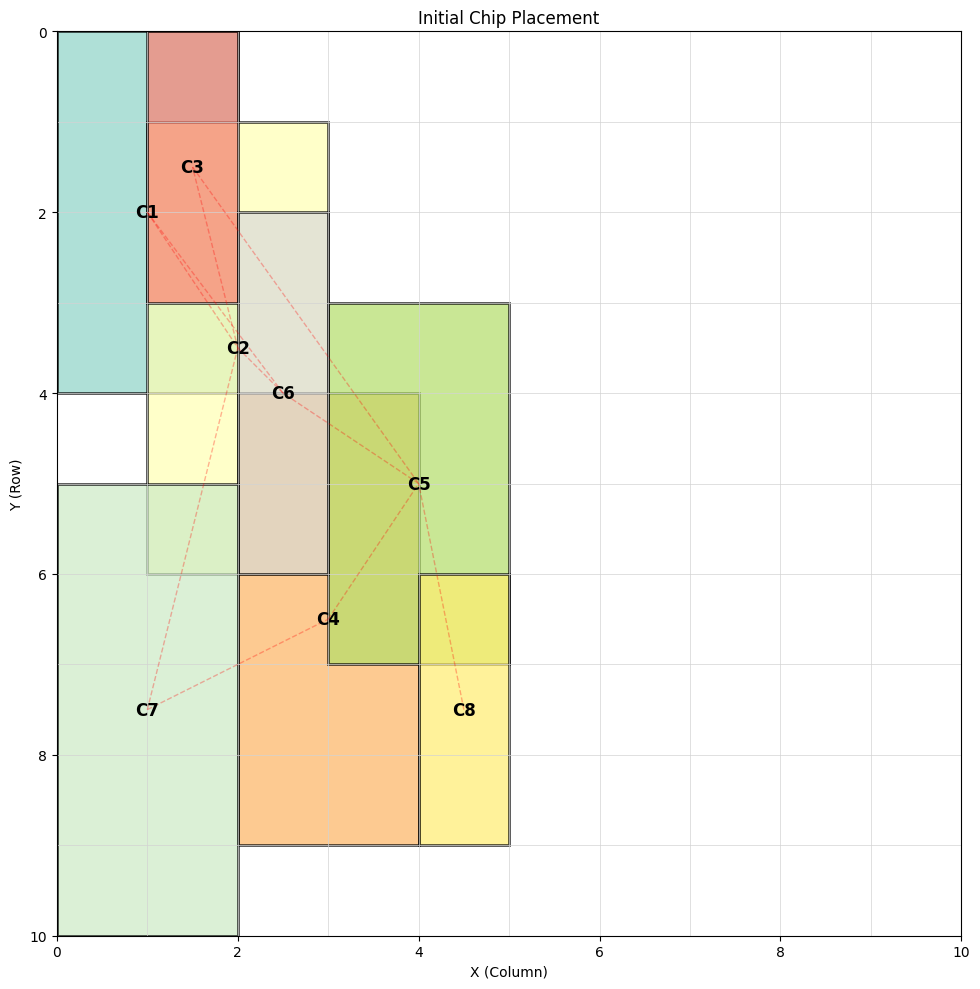


Starting Integer Descent Optimization
Initial conflict score: 32
Moving Chip 3 from x=1 to x=3 (conflict: 32 -> 30)
Moving Chip 5 from x=3 to x=4 (conflict: 30 -> 28)
Moving Chip 8 from x=4 to x=6 (conflict: 28 -> 27)

Converged at iteration 4

Optimization Complete
Final conflict score: 27
Improvement: 5 (15.6%)
Total iterations: 4

Final chip positions:
  Chip 1: x=0, y=0 (row-locked)
  Chip 2: x=1, y=1 (row-locked)
  Chip 3: x=3, y=0 (row-locked)
  Chip 4: x=2, y=4 (row-locked)
  Chip 5: x=4, y=3 (row-locked)
  Chip 6: x=2, y=2 (row-locked)
  Chip 7: x=0, y=5 (row-locked)
  Chip 8: x=6, y=6 (row-locked)

Visualizing final placement...


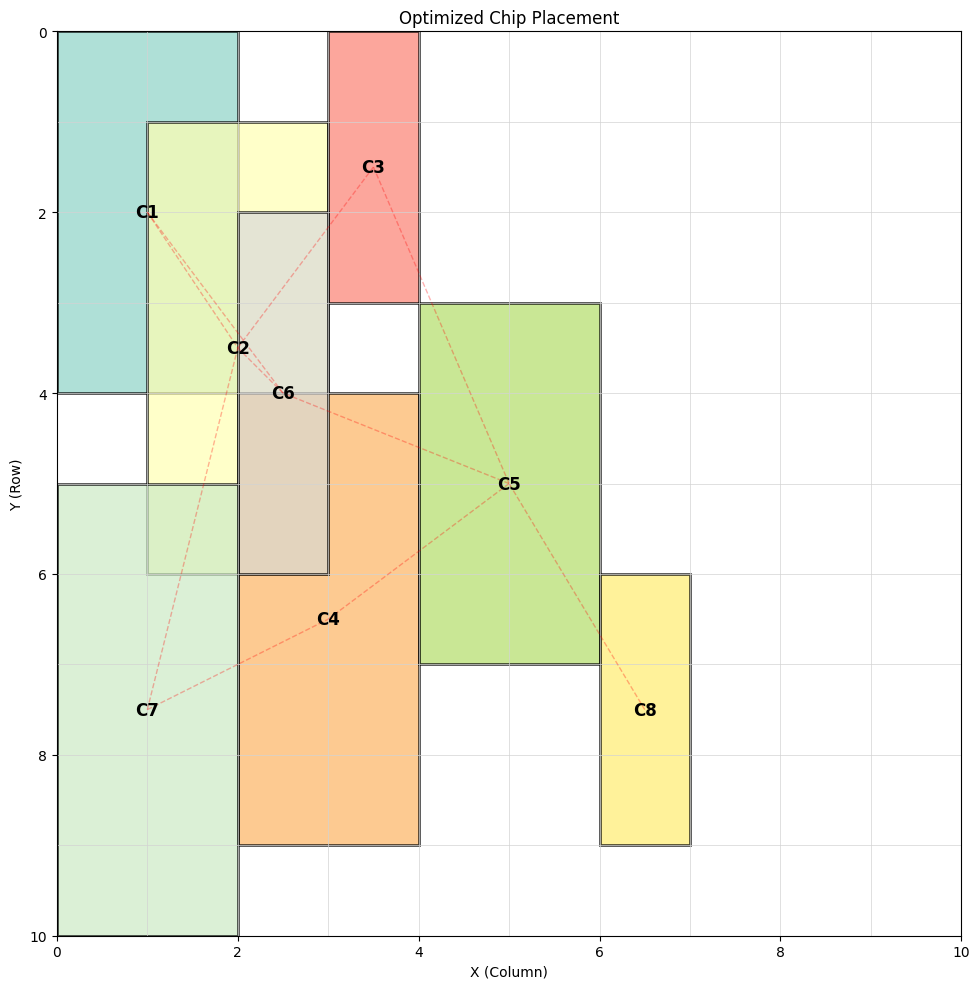


Plotting convergence...


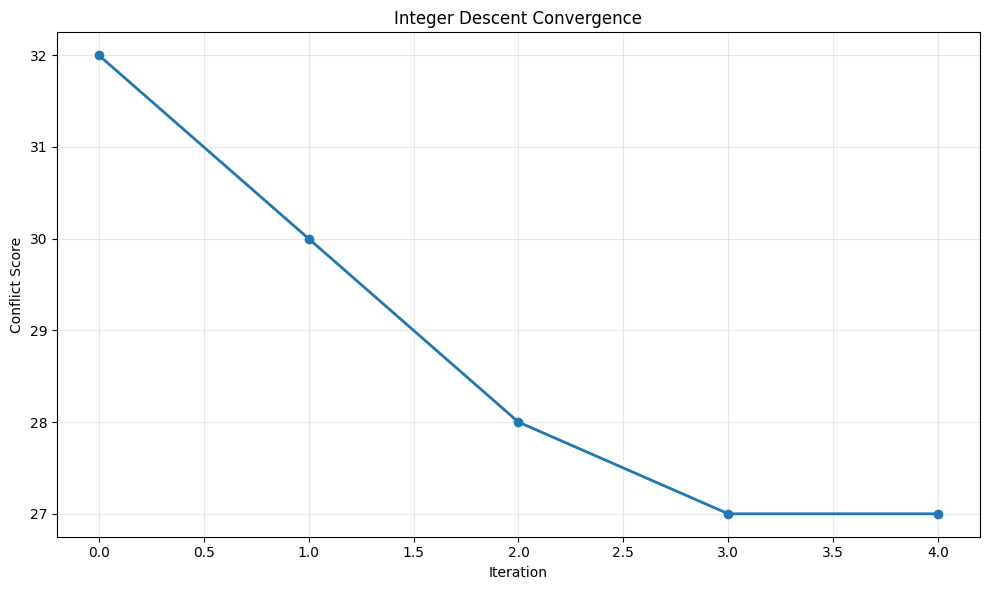


Detailed Analysis
Number of overlapping blocks: 8

Individual wiring costs:
  Connection (1, 2): 1
  Connection (2, 6): 1
  Connection (2, 3): 1
  Connection (3, 5): 3
  Connection (4, 5): 1
  Connection (5, 6): 2
  Connection (1, 6): 2
  Connection (7, 4): 1
  Connection (7, 2): 4
  Connection (8, 5): 3

Total wiring cost: 19
Total overlap cost: 8
Total conflict score: 27


In [1]:
"""
Q)4 Chip Placement Optimization using Integer Descent
Column-wise Restricted Movement

This program implements an integer descent algorithm to optimize chip placement
on a grid, minimizing wire lengths between connected chips and overlap penalties.
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import copy

class Chip:
    """
    Represents a single chip/module to be placed on the grid.

    Attributes:
        id (int): Unique identifier for the chip
        width (int): Width of the chip
        height (int): Height of the chip
        locked_row (int): The row this chip is locked to
        x (int): Current x-coordinate (column) position
    """
    def __init__(self, chip_id: int, width: int, height: int, locked_row: int, initial_x: int):
        self.id = chip_id
        self.width = width
        self.height = height
        self.locked_row = locked_row
        self.x = initial_x

    def __repr__(self):
        return f"Chip{self.id}(w={self.width}, h={self.height}, row={self.locked_row}, x={self.x})"

class ChipPlacementOptimizer:
    """
    Implements integer descent optimization for chip placement problem.

    The optimizer minimizes a conflict score consisting of:
    1. Wiring cost: Manhattan distance between connected chips
    2. Overlap cost: Number of grid cells occupied by multiple chips
    """

    def __init__(self, grid_width: int = 10, grid_height: int = 10):
        """
        Initialize the chip placement optimizer.

        Args:
            grid_width (int): Width of the placement grid
            grid_height (int): Height of the placement grid
        """
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.chips = []
        self.connections = []
        self.conflict_history = []

    def setup_initial_state(self):
        """
        Set up the initial chip configuration as specified in the problem.
        """
        # Create chips with their specifications (id, width, height, locked_row, initial_x)
        chip_specs = [
            (1, 2, 4, 0, 0),  # c1: 2×4 at row y=0, x=0
            (2, 2, 5, 1, 1),  # c2: 2×5 at row y=1, x=1
            (3, 1, 3, 0, 1),  # c3: 1×3 at row y=0, x=1
            (4, 2, 5, 4, 2),  # c4: 2×5 at row y=4, x=2
            (5, 2, 4, 3, 3),  # c5: 2×4 at row y=3, x=3
            (6, 1, 4, 2, 2),  # c6: 1×4 at row y=2, x=2
            (7, 2, 5, 5, 0),  # c7: 2×5 at row y=5, x=0
            (8, 1, 3, 6, 4),  # c8: 1×3 at row y=6, x=4
        ]

        self.chips = []
        for chip_id, width, height, locked_row, initial_x in chip_specs:
            chip = Chip(chip_id, width, height, locked_row, initial_x)
            self.chips.append(chip)

        # Define connections (netlist) as pairs of chip IDs
        self.connections = [
            (1, 2), (2, 6), (2, 3), (3, 5), (4, 5),
            (5, 6), (1, 6), (7, 4), (7, 2), (8, 5)
        ]

        print("Initial chip configuration:")
        for chip in self.chips:
            print(f"  {chip}")

    def get_chip_by_id(self, chip_id: int) -> Chip:
        """Get a chip object by its ID."""
        for chip in self.chips:
            if chip.id == chip_id:
                return chip
        return None

    def calculate_wiring_cost(self, c_i: Chip, c_j: Chip) -> int:
        """
        Calculate the wiring cost between two connected chips.

        The cost is the Manhattan distance between chip boundaries plus
        the vertical distance between their locked rows.

        Args:
            c_i (Chip): First chip
            c_j (Chip): Second chip

        Returns:
            int: Wiring cost
        """
        # Calculate horizontal distance between chips
        x_i_right = c_i.x + c_i.width
        x_j_right = c_j.x + c_j.width

        # Manhattan distance formula as specified
        horizontal_dist = max(0, c_j.x - x_i_right, c_i.x - x_j_right)
        vertical_dist = abs(c_i.locked_row - c_j.locked_row)

        return horizontal_dist + vertical_dist

    def get_grid_representation(self) -> np.ndarray:
        """
        Create a grid representation showing which chips occupy which cells.

        Returns:
            np.ndarray: Grid where each cell contains the chip ID (0 if empty)
        """
        grid = np.zeros((self.grid_height, self.grid_width), dtype=int)

        for chip in self.chips:
            # Mark all cells occupied by this chip
            for dy in range(chip.height):
                for dx in range(chip.width):
                    y = chip.locked_row + dy
                    x = chip.x + dx
                    if 0 <= y < self.grid_height and 0 <= x < self.grid_width:
                        if grid[y, x] == 0:
                            grid[y, x] = chip.id
                        else:
                            # Mark overlap with negative value
                            grid[y, x] = -1

        return grid

    def calculate_overlap_blocks(self) -> int:
        """
        Calculate the number of grid blocks occupied by more than one chip.

        Returns:
            int: Number of overlapping grid cells
        """
        overlap_count = 0
        grid_occupancy = {}  # Dictionary to track which chips occupy each cell

        for chip in self.chips:
            for dy in range(chip.height):
                for dx in range(chip.width):
                    y = chip.locked_row + dy
                    x = chip.x + dx
                    if 0 <= y < self.grid_height and 0 <= x < self.grid_width:
                        cell = (y, x)
                        if cell not in grid_occupancy:
                            grid_occupancy[cell] = []
                        grid_occupancy[cell].append(chip.id)

        # Count cells with more than one chip
        for cell, chip_ids in grid_occupancy.items():
            if len(chip_ids) > 1:
                overlap_count += 1

        return overlap_count

    def calculate_total_conflict(self) -> int:
        """
        Calculate the total conflict score (wiring cost + overlap cost).

        Returns:
            int: Total conflict score
        """
        # Calculate wiring cost for all connections
        total_wiring_cost = 0
        for c_i_id, c_j_id in self.connections:
            c_i = self.get_chip_by_id(c_i_id)
            c_j = self.get_chip_by_id(c_j_id)
            if c_i and c_j:
                total_wiring_cost += self.calculate_wiring_cost(c_i, c_j)

        # Calculate overlap cost
        overlap_blocks = self.calculate_overlap_blocks()

        total_conflict = total_wiring_cost + overlap_blocks

        return total_conflict

    def get_valid_moves(self, chip: Chip) -> List[int]:
        """
        Get all valid integer x-positions for a chip (within grid bounds).

        Args:
            chip (Chip): The chip to move

        Returns:
            List[int]: List of valid x-positions
        """
        valid_positions = []
        for x in range(self.grid_width - chip.width + 1):
            valid_positions.append(x)
        return valid_positions

    def integer_descent_step(self) -> bool:
        """
        Perform one step of integer descent optimization.

        Returns:
            bool: True if improvement was found, False otherwise
        """
        current_conflict = self.calculate_total_conflict()
        best_conflict = current_conflict
        best_move = None

        # Try moving each chip to all possible integer positions
        for chip in self.chips:
            original_x = chip.x
            valid_positions = self.get_valid_moves(chip)

            for new_x in valid_positions:
                if new_x == original_x:
                    continue

                # Try the move
                chip.x = new_x
                new_conflict = self.calculate_total_conflict()

                # Check if this is the best move so far
                if new_conflict < best_conflict:
                    best_conflict = new_conflict
                    best_move = (chip, new_x)

                # Restore original position
                chip.x = original_x

        # Apply the best move if found
        if best_move:
            chip, new_x = best_move
            print(f"Moving Chip {chip.id} from x={chip.x} to x={new_x} (conflict: {current_conflict} -> {best_conflict})")
            chip.x = new_x
            return True

        return False

    def optimize(self, max_iterations: int = 100) -> Dict:
        """
        Run the integer descent optimization algorithm.

        Args:
            max_iterations (int): Maximum number of optimization iterations

        Returns:
            Dict: Optimization results including final positions and conflict score
        """
        print("\n" + "="*60)
        print("Starting Integer Descent Optimization")
        print("="*60)

        # Record initial conflict
        initial_conflict = self.calculate_total_conflict()
        self.conflict_history = [initial_conflict]
        print(f"Initial conflict score: {initial_conflict}")

        # Run integer descent
        iteration = 0
        while iteration < max_iterations:
            iteration += 1

            # Perform one descent step
            improved = self.integer_descent_step()

            # Record conflict score
            current_conflict = self.calculate_total_conflict()
            self.conflict_history.append(current_conflict)

            # Check for convergence
            if not improved:
                print(f"\nConverged at iteration {iteration}")
                break

        # Get final results
        final_conflict = self.calculate_total_conflict()

        print("\n" + "="*60)
        print("Optimization Complete")
        print("="*60)
        print(f"Final conflict score: {final_conflict}")
        print(f"Improvement: {initial_conflict - final_conflict} ({(initial_conflict - final_conflict)/initial_conflict*100:.1f}%)")
        print(f"Total iterations: {iteration}")

        # Print final chip positions
        print("\nFinal chip positions:")
        for chip in sorted(self.chips, key=lambda c: c.id):
            print(f"  Chip {chip.id}: x={chip.x}, y={chip.locked_row} (row-locked)")

        return {
            'initial_conflict': initial_conflict,
            'final_conflict': final_conflict,
            'iterations': iteration,
            'conflict_history': self.conflict_history,
            'final_positions': [(chip.id, chip.x, chip.locked_row) for chip in self.chips]
        }

    def visualize_placement(self, title: str = "Chip Placement"):
        """
        Visualize the current chip placement on the grid.

        Args:
            title (str): Title for the visualization
        """
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        # Draw grid
        for i in range(self.grid_height + 1):
            ax.axhline(y=i, color='lightgray', linewidth=0.5)
        for i in range(self.grid_width + 1):
            ax.axvline(x=i, color='lightgray', linewidth=0.5)

        # Color map for chips
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.chips)))

        # Draw chips
        for idx, chip in enumerate(self.chips):
            rect = plt.Rectangle((chip.x, chip.locked_row),
                                chip.width, chip.height,
                                facecolor=colors[idx],
                                edgecolor='black',
                                linewidth=2,
                                alpha=0.7)
            ax.add_patch(rect)

            # Add chip label
            ax.text(chip.x + chip.width/2, chip.locked_row + chip.height/2,
                   f'C{chip.id}', ha='center', va='center',
                   fontsize=12, fontweight='bold')

        # Draw connections
        for c_i_id, c_j_id in self.connections:
            c_i = self.get_chip_by_id(c_i_id)
            c_j = self.get_chip_by_id(c_j_id)
            if c_i and c_j:
                # Connection from center of chips
                x1 = c_i.x + c_i.width/2
                y1 = c_i.locked_row + c_i.height/2
                x2 = c_j.x + c_j.width/2
                y2 = c_j.locked_row + c_j.height/2
                ax.plot([x1, x2], [y1, y2], 'r--', alpha=0.3, linewidth=1)

        ax.set_xlim(0, self.grid_width)
        ax.set_ylim(0, self.grid_height)
        ax.set_aspect('equal')
        ax.invert_yaxis()  # Invert y-axis to match matrix representation
        ax.set_xlabel('X (Column)')
        ax.set_ylabel('Y (Row)')
        ax.set_title(title)

        plt.tight_layout()
        plt.show()

    def plot_convergence(self):
        """Plot the convergence of the conflict score over iterations."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.conflict_history, marker='o', linewidth=2, markersize=6)
        plt.xlabel('Iteration')
        plt.ylabel('Conflict Score')
        plt.title('Integer Descent Convergence')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def main():
    """
    Main function to run the chip placement optimization.
    """
    # Create optimizer instance
    optimizer = ChipPlacementOptimizer(grid_width=10, grid_height=10)

    # Set up initial state
    optimizer.setup_initial_state()

    # Visualize initial placement
    print("\nVisualizing initial placement...")
    optimizer.visualize_placement("Initial Chip Placement")

    # Run optimization
    results = optimizer.optimize(max_iterations=100)

    # Visualize final placement
    print("\nVisualizing final placement...")
    optimizer.visualize_placement("Optimized Chip Placement")

    # Plot convergence
    print("\nPlotting convergence...")
    optimizer.plot_convergence()

    # Print detailed overlap analysis
    print("\n" + "="*60)
    print("Detailed Analysis")
    print("="*60)

    overlap_blocks = optimizer.calculate_overlap_blocks()
    print(f"Number of overlapping blocks: {overlap_blocks}")

    # Calculate and print wiring costs for each connection
    print("\nIndividual wiring costs:")
    total_wiring = 0
    for c_i_id, c_j_id in optimizer.connections:
        c_i = optimizer.get_chip_by_id(c_i_id)
        c_j = optimizer.get_chip_by_id(c_j_id)
        if c_i and c_j:
            cost = optimizer.calculate_wiring_cost(c_i, c_j)
            total_wiring += cost
            print(f"  Connection ({c_i_id}, {c_j_id}): {cost}")

    print(f"\nTotal wiring cost: {total_wiring}")
    print(f"Total overlap cost: {overlap_blocks}")
    print(f"Total conflict score: {total_wiring + overlap_blocks}")

    return results


if __name__ == "__main__":
    results = main()